In [1]:
import networkx as nx
import osmnx as ox
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point
import json


%matplotlib inline

* czy daloby sie wykryc odcinki, gdzie autobus moglby nadrobic spoznienia?
* jak dlugo autobus jechal miedzy przystankami w stosunku do tego ile faktycznie moglby jechac
* jak czasy przejazdu po trasach maja sie do godzin szczytowych vs luznych
* wytrenowac model przewidujący opóźnienia (wagi krawędzi w grafie)

## Dane

Dane bierzemy z Overpassa przy pomocy takiego querry (http://overpass-turbo.eu/):

```
[out:json][timeout:25];
(
  area['name'='Wrocław'];
  //(node['railway'='tram_stop'](area););
  //(node['highway'='bus_stop'](area););
  (relation['route'='tram'](area);); // dla linii tramwajowych
  (relation['route'='bus'](area);); // dla linii autobusowych
);
out body;
>;
out skel qt;wroc = ox.geocode_to_gdf("Wrocław, Poland", which_result=1)
```

***

### Graf dróg Wrocławia (osmnx)

In [2]:
roads_graph = ox.graph_from_place(
    "Wrocław, Poland", 
    network_type="drive",
)

In [3]:
# ox.plot_graph(roads_graph)

### **Wrocław open data**

In [4]:
routes_od = pd.read_csv("dane/routes.txt")
stops_od = pd.read_csv("dane/stops.txt")
trips_od = pd.read_csv("dane/trips.txt")
stop_times_od = pd.read_csv("dane/stop_times.txt")

stops_od = gpd.GeoDataFrame(stops_od, geometry=gpd.points_from_xy(stops_od.stop_lon.values, stops_od.stop_lat.values), crs='EPSG:3395').drop(["stop_lat", "stop_lon"], axis=1)
gdf = gpd.GeoDataFrame(stop_times_od.merge(stops_od, on='stop_id'))

stops_od.rename(columns={"stop_name": "name"}, inplace=True)
stops_od['geometry'] = [Point(round(el, 3) for el in p.coords[0]) for p in stops_od.geometry.values]
stops_od['coords'] = [p.coords[0] for p in stops_od.geometry.values]
stops_od.drop('geometry', axis=1, inplace=True)

### **OMNX**

In [5]:
bus_stops_ox = ox.geometries_from_place("Wrocław, Poland", tags={'highway': 'bus_stop'}).loc['node']
tram_stops_ox = ox.geometries_from_place("Wrocław, Poland", tags={'railway': 'tram_stop'}).loc['node']

wroc = ox.geocode_to_gdf("Wrocław, Poland")

### **Overpass**

In [6]:
tram_op = gpd.read_file("dane/tram.geojson")
bus_op = gpd.read_file("dane/bus.geojson")


tram_op = tram_op[tram_op.within(wroc.iloc[0].geometry.buffer(0.05))]
bus_op = bus_op[bus_op.within(wroc.iloc[0].geometry.buffer(0.05))]

bus_stops_op = bus_op[bus_op['route'] != 'bus'].dropna(axis=1, how='all')
bus_routes_op = bus_op[bus_op['route'] == 'bus']

tram_stops_op = tram_op[tram_op['route'] != 'tram'].dropna(axis=1, how='all')
tram_routes_op = tram_op[tram_op['route'] == 'tram']

## Mergowanie danych

### Bus

In [7]:
bus_stops_ox['osm_id'] = bus_stops_ox.index.values
bus_stops_ox['geometry'] = [Point(round(el, 3) for el in p.coords[0]) for p in bus_stops_ox.geometry.values]
bus_stops_ox['coords'] = [p.coords[0] for p in bus_stops_ox.geometry.values]
bus_stops_ox.drop('name', axis=1, inplace=True)

bus_stops_op['osm_id'] = [int(el.split("/")[1]) for el in bus_stops_op['id']]
bus_stops_op.drop(['id', '@id'], axis=1, inplace=True)

bus_stops_final = bus_stops_ox.merge(stops_od, on="coords")[['osm_id', 'stop_id', 'stop_code', 'name', 'geometry']]
bus_stops_final = bus_stops_final.drop('geometry', axis=1).merge(bus_stops_op, on='osm_id')

bus_stops_final['name_coded'] = [f"{name}-{num}" for name, num in zip (bus_stops_final['name'].values, bus_stops_final['stop_code'].values)]

### Tram

In [8]:
tram_stops_ox['osm_id'] = tram_stops_ox.index.values
tram_stops_ox['geometry'] = [Point(round(el, 3) for el in p.coords[0]) for p in tram_stops_ox.geometry.values]
tram_stops_ox['coords'] = [p.coords[0] for p in tram_stops_ox.geometry.values]
tram_stops_ox.drop('name', axis=1, inplace=True)

tram_stops_op['osm_id'] = [int(el.split("/")[1]) for el in tram_stops_op['id']]
tram_stops_op.drop(['id', '@id'], axis=1, inplace=True)

tram_stops_final = tram_stops_ox.merge(stops_od, on="coords")[['osm_id', 'stop_id', 'stop_code', 'name', 'geometry']]
tram_stops_final = tram_stops_final.drop('geometry', axis=1).merge(tram_stops_op, on='osm_id')

tram_stops_final['name_coded'] = [f"{name}-{num}" for name, num in zip (tram_stops_final['name'].values, tram_stops_final['stop_code'].values)]

## **Visualize**

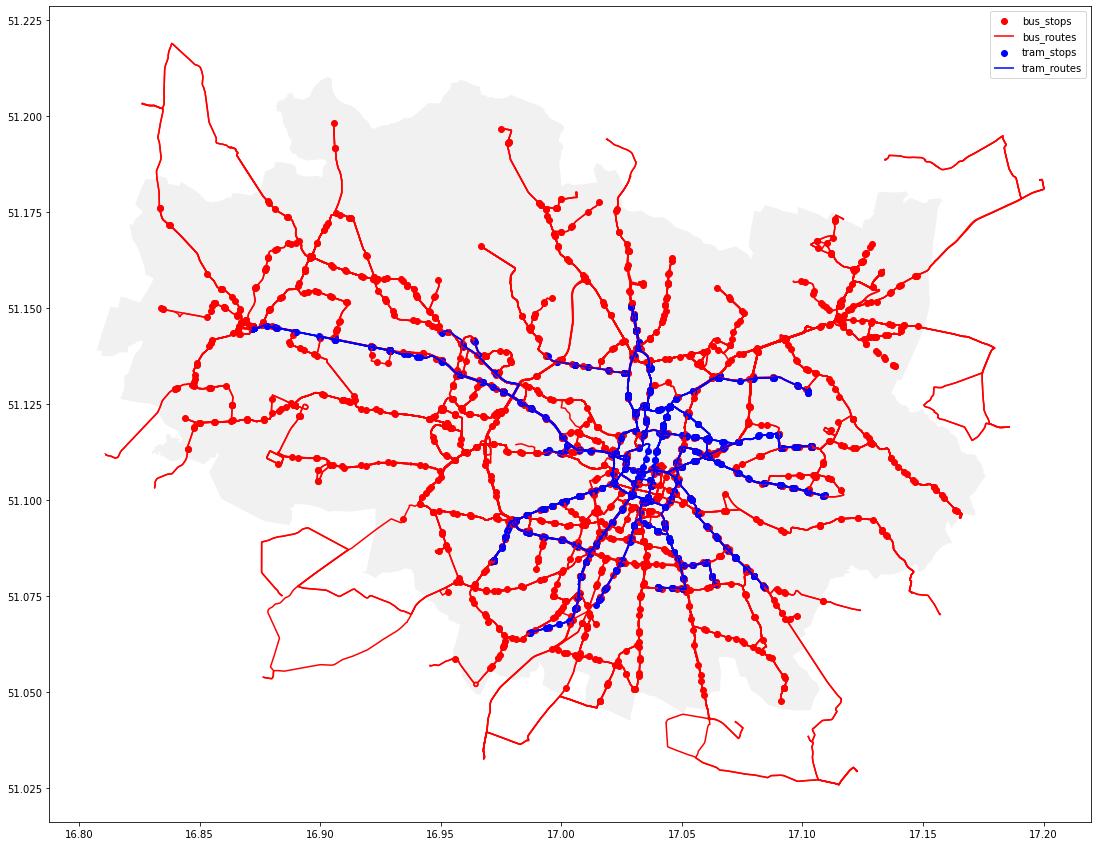

In [9]:
fig, ax = plt.subplots(figsize=(30, 15))

wroc.plot(ax=ax, color='lightgrey', alpha=0.3)


bus_stops_final.plot(color='red', ax=ax, label='bus_stops')
bus_routes_op.plot(color='red', ax=ax, label='bus_routes')

tram_stops_final.plot(color='blue', ax=ax, label='tram_stops')
tram_routes_op.plot(color='blue', ax=ax, label='tram_routes')


plt.legend()

In [10]:
routes = pd.read_csv("routes_df.csv")

In [11]:
gdf_nodes = gpd.GeoDataFrame(crs='EPSG:3395')
gdf_nodes['osmid'] = bus_stops_final['osm_id']
gdf_nodes['x'] = [p.coords[0][0] for p in bus_stops_final.geometry.values]
gdf_nodes['y'] = [p.coords[0][1] for p in bus_stops_final.geometry.values]
gdf_nodes['geometry'] = bus_stops_final.geometry.values
gdf_nodes['name_coded'] = bus_stops_final['name_coded'].values
gdf_nodes.set_index('osmid', inplace=True)

/tmp/ipykernel_209/1920207875.py:1: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  gdf_nodes = gpd.GeoDataFrame(crs='EPSG:3395')


In [13]:
from shapely.geometry import LineString

rows = []
for edge in routes.iterrows():
    edge = edge[1]
    source = edge['source']
    target = edge['target']
    if source in gdf_nodes['name_coded'].values and target in gdf_nodes['name_coded'].values:
        source = bus_stops_final[bus_stops_final['name_coded'] == source].iloc[0]
        target = bus_stops_final[bus_stops_final['name_coded'] == target].iloc[0]
        rows.append({
            'u': source['osm_id'],
            'v': target['osm_id'],
            'geometry': LineString([source['geometry'].coords[0], target['geometry'].coords[0]]),
            'source_name': source['name_coded'],
            'target_name': target['name_coded'],
            "key": 0
        })

In [14]:
gdf_edges = gpd.GeoDataFrame.from_dict(rows, crs='EPSG:3395').set_index(['u', 'v', 'key'])

/opt/conda/lib/python3.9/site-packages/geopandas/geodataframe.py:475: FutureWarning: CRS mismatch between CRS of the passed geometries and 'crs'. Use 'GeoDataFrame.set_crs(crs, allow_override=True)' to overwrite CRS or 'GeoDataFrame.to_crs(crs)' to reproject geometries. CRS mismatch will raise an error in the future versions of GeoPandas.
  return GeoDataFrame(dataframe, geometry=geometry, crs=crs)


In [15]:
G = ox.graph_from_gdfs(
    gdf_nodes.drop('name_coded', axis=1).drop_duplicates(),
    gdf_edges.drop_duplicates()
)

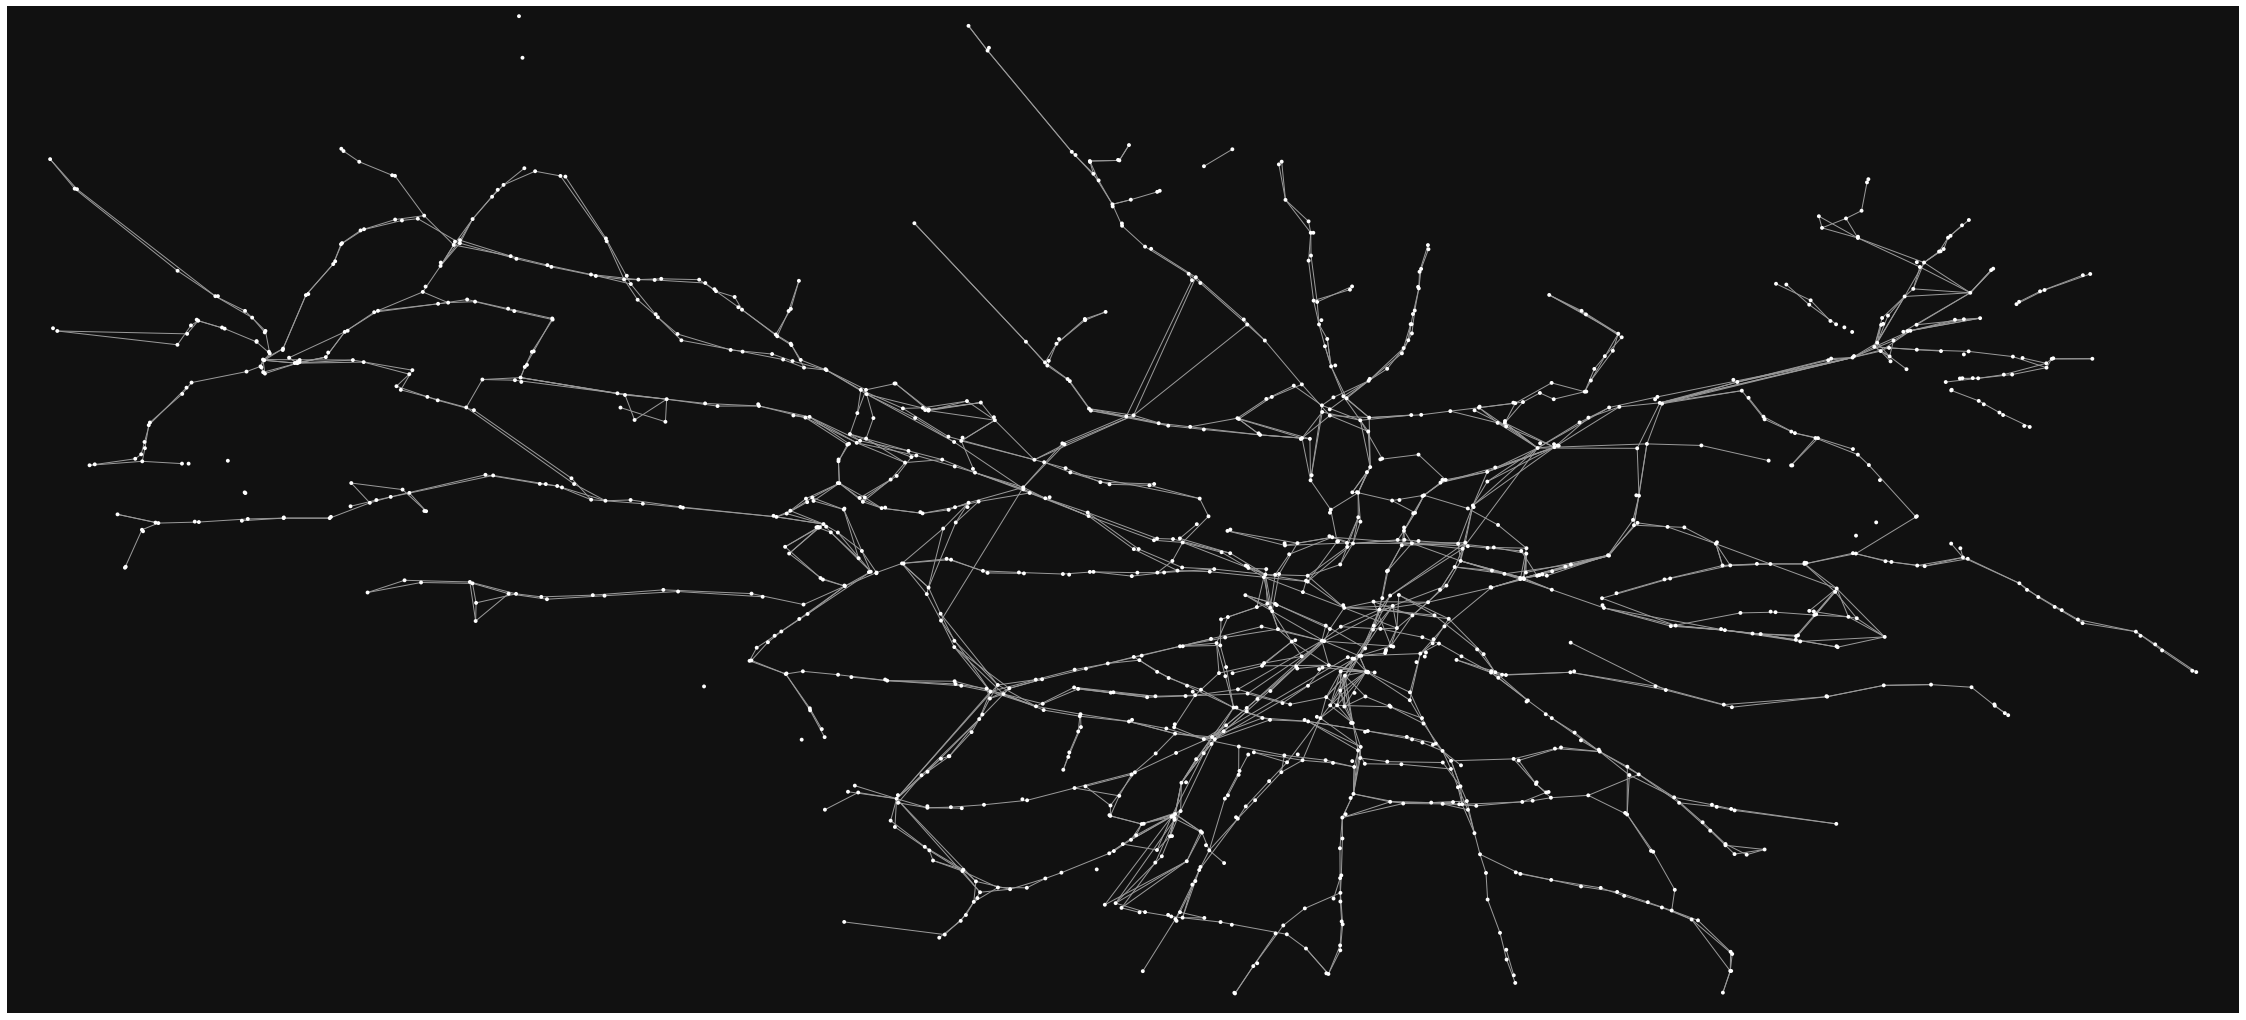

(<Figure size 2880x1440 with 1 Axes>, <AxesSubplot:>)

In [16]:
ox.plot_graph(G, figsize=(40, 20))